# Ch10 Analyzing the Meaning of Sentences

本章的目標是回答下列問題

1. 如何在電腦中表示自然語言的意義?
2. 如何將意義與某個句子的集合產生關聯?
3. 如何用意義與句子間的聯繫來儲存知識?

## Natural Language Understanding

假設在資料庫中，我們儲存了各國的國名、首都名、人口，電腦要如何回答"Which country is Athens in?"這類的問題?

一個直觀的方法，就是用Ch9所介紹的feature-based grammar，將資料庫的查詢語法(例如SQL語法)放在feature中:

In [1]:
import nltk

In [2]:
grammar = nltk.grammar.FeatureGrammar.fromstring("""
    % start S
    S[SEM=(?np + WHERE + ?vp)] -> NP[SEM=?np] VP[SEM=?vp]
    VP[SEM=(?v + ?pp)] -> IV[SEM=?v] PP[SEM=?pp]
    VP[SEM=(?v + ?ap)] -> IV[SEM=?v] AP[SEM=?ap]
    NP[SEM=(?det + ?n)] -> Det[SEM=?det] N[SEM=?n]
    PP[SEM=(?p + ?np)] -> P[SEM=?p] NP[SEM=?np]
    AP[SEM=?pp] -> A[SEM=?a] PP[SEM=?pp]
    NP[SEM='Country="greece"'] -> 'Greece'
    NP[SEM='Country="china"'] -> 'China'
    Det[SEM='SELECT'] -> 'Which' | 'What'
    N[SEM='City FROM city_table'] -> 'cities'
    IV[SEM=''] -> 'are'
    A[SEM=''] -> 'located'
    P[SEM=''] -> 'in'
    """)

In [3]:
parser = nltk.parse.FeatureEarleyChartParser(grammar)
trees = parser.parse('What cities are located in China'.split())

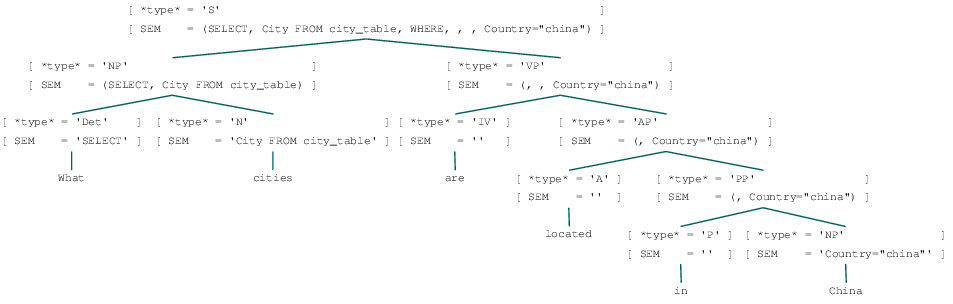

In [4]:
t = trees.next()
t

In [5]:
print ' '.join(t.label()['SEM'])

SELECT City FROM city_table WHERE   Country="china"


## Propositional Logic

In [6]:
# nltk有支援的logic operators
nltk.boolean_ops()

negation       	-
conjunction    	&
disjunction    	|
implication    	->
equivalence    	<->


In [7]:
nltk.equality_preds()

equality       	=
inequality     	!=


In [8]:
nltk.binding_ops()

existential    	exists
universal      	all
lambda         	\


In [61]:
# LogicParser可以將邏輯字串轉換成expression
lp = nltk.logic.LogicParser()
lp.parse('-(P & Q)')

<NegatedExpression -(P & Q)>

In [66]:
val = nltk.Valuation([('P', True), ('Q', False), ('R', False)])
m = nltk.Model(set(), val)

In [67]:
print m.evaluate('(P & Q)', nltk.Assignment(set()))

False


In [68]:
print m.evaluate('(P | Q)', nltk.Assignment(set()))

True


## First-Order Logic

first-order logic由以下幾種元素組成:

1. **terms**: 個體變數、個體常數兩種
2. **predicates**: 相當於function，可以接受任意參數，並決定某種動作或狀態

下面會介紹Typed-Logic，有`e`(代表entity/term)、`t`(代表formula)兩種basic type。多個basic type可以組成complex type，例如`<e,t>`或`<e,<e,t>>`等等。

In [12]:
from nltk.sem.logic import LogicParser
tlp = LogicParser(True)

In [30]:
# function本身是一種complex type <e,?>
#   之所以有 ? 是因為我們沒有指定walk的type
# John是一個entity，所以屬於basic type e
john_walk = tlp.parse('walk(John)')
print john_walk.function, john_walk.function.type, john_walk.argument, john_walk.argument.type

walk <e,?> John e


In [31]:
# 要指定function的type，可以用signature來指定
walk_sig = {'walk': '<e, t>'}
john_walk = tlp.parse('walk(John)', walk_sig)
print john_walk.function, john_walk.function.type, john_walk.argument, john_walk.argument.type

walk <e,t> John e


In [40]:
# existential quantifier
tlp.parse('exists x.(dog(x) & disappear(x))')

<ExistsExpression exists x.(dog(x) & disappear(x))>

In [42]:
# universal quantifier
tlp.parse('all x.(dog(x) -> disappear(x))')

<AllExpression all x.(dog(x) -> disappear(x))>

In [43]:
# 在formula中的變數，如果只有一個字元，會被當成free variable
tlp.parse('dog(Cyril)').free()

set()

In [47]:
tlp.parse('dog(x)').free()

{Variable('x')}

In [48]:
tlp.parse('exists x.own(y, x)').free()

{Variable('y')}

### Proving

`if x is to the north of y then y is not to the north of x`

In [64]:
prover = nltk.Prover9()
prover.config_prover9('C:/Program Files (x86)/LADR1007B-win/bin')

In [65]:
north_formula = tlp.parse('all x. all y.(north_of(x, y) -> -north_of(y, x))')
fact = tlp.parse('north_of(Taipei, Tainan)')
unknown = tlp.parse('-north_of(Tainan, Taipei)')
prover.prove(unknown, [fact, north_formula])

True

### Model

一個model M，如果用在first-order logic language L上，則定義為`M = <D, Val>`。其中`D`稱為domain，`Val`稱為valuation function。

`Val`的用途是將L中的individual constant及predicate symbol都賦予一個屬於domain的值。

In [67]:
from nltk.sem import Valuation, Model
v = [('adam', 'b1'), ('betty', 'g1'), ('fido', 'd1'),
     ('girl', set(['g1', 'g2'])), ('boy', set(['b1', 'b2'])),
     ('dog', set(['d1'])),
     ('love', set([('b1', 'g1'), ('b2', 'g2'), ('g1', 'b1'), ('g2', 'b1')]))]
val = Valuation(v)
dom = val.domain
m = Model(dom, val)

In [68]:
dom

{'b1', 'b2', 'd1', 'g1', 'g2'}

In [74]:
m.evaluate('love(fido, betty)', nltk.Assignment(dom))

False

In [75]:
m.evaluate('love(adam, betty)', nltk.Assignment(dom))

True

In [76]:
m.evaluate('love(john, betty)', nltk.Assignment(dom))

u'Undefined'